In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score

## The essence of the hidden layer

We know two things:

* Neural networks are basically logistic regression.
* Gradient descent can get us real far.

Here's an idea just crazy enough it might work:

* What if we do logistic regression in order to classify our samples as some _latent things_.
* And then we do logistic regression using the _latent things_ as features.

For example:

* Take the Fantasy Uber Churn dataset
* Predict if each sample is
 * A business traveler
 * A casual traveler
 * A real jerk
 * A late night party animal
 * Any number of other personas
* Once we've established which categories they belong in, use that to predict if they'll churn.

To discover this "hidden layer" of personas, we'll just initalize feature->persona and persona->churn connections at random, and use the gradient of the loss to slowly move the weights to improve the final loss.

Hopefull, this will result in the discovery of the intermediate hidden layer.


## get that data

Let's grab the Fantasy Uber dataset.

In [2]:
df = pd.read_csv("churn.csv", parse_dates=["last_trip_date","signup_date"])

In [3]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
today = df.last_trip_date.max()

Engineer some features.

In [5]:
city_dummies = pd.get_dummies(df.pop("city"))
phone_dummies = pd.get_dummies(df.pop("phone"))
df["signup_dow"] = df.signup_date.dt.weekday
df["age"] = (today - df.signup_date).dt.days
df["pass_rating_blank"] = df.avg_rating_by_driver.isna()
df["driver_rating_blank"] = df.avg_rating_of_driver.isna()
df["avg_rating_by_driver"] = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df["avg_rating_of_driver"] = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

Engineer the target, a binary variable for churn.

In [6]:
y = (df.last_trip_date <= today-timedelta(days=30)).astype(float).values
y = np.expand_dims(y, axis=1)

Drop non-numeric columns and get the raw matrix.

In [7]:
df = df.drop(["last_trip_date","signup_date"], axis=1)
X = df.values.astype(float)

The model proceeds in two steps. In the first step, we make a random guess about the linear mapping of the 12 input features to 6 output features, and then apply a matrix to get the output features:

In [8]:
np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

In [10]:
X @ W_hidden + b_hidden

<tf.Tensor: id=23, shape=(50000, 6), dtype=float64, numpy=
array([[ 157.51801023,  123.42623012, -224.01717846,  -76.56557536,
          14.25859132,  192.57573125],
       [ 164.94845967,  115.62099873, -205.83461763,  -71.8160556 ,
          17.04969972,  199.22173678],
       [ 176.49691555,  133.44306734, -303.39512446, -128.33701125,
           7.92108939,  271.16321516],
       ...,
       [ 155.8146044 ,   93.8258662 , -281.61212978, -114.46447596,
          -6.22986826,  252.55168131],
       [ 168.40335502,  123.18683328, -290.92950499, -119.47080611,
           4.89119767,  264.58938538],
       [ 180.56497915,  138.0565267 , -142.20821978,  -48.06636208,
          43.57663036,  161.46131166]])>

Then we use a sigmoid function to squish the linear output features to a range between 0 and 1.

In [20]:
unseen_activation = tf.sigmoid( X @ W_hidden + b_hidden ).numpy().astype(np.float16)
unseen_activation

array([[1.      , 1.      , 0.      , 0.      , 1.      , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 1.      , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 0.9995  , 1.      ],
       ...,
       [1.      , 1.      , 0.      , 0.      , 0.001966, 1.      ],
       [1.      , 1.      , 0.      , 0.      , 0.9927  , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 1.      , 1.      ]],
      dtype=float16)

Every row of the output corresponds to an input sample, and every column responds to an unseen "feature".

In [22]:
unseen_activation.shape

(50000, 6)

In [23]:
unseen_activation[0]

array([1., 1., 0., 0., 1., 1.], dtype=float16)

In the second stage, we take the unseen layer, and apply an arbirary set of weights and biases to calculate a sigmoid output.

In [24]:
#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [30]:
yhat = tf.sigmoid( unseen_activation @ W_final + b_final )
yhat

<tf.Tensor: id=124, shape=(50000, 1), dtype=float64, numpy=
array([[0.98201379],
       [0.98201379],
       [0.98200516],
       ...,
       [0.95266289],
       [0.98188397],
       [0.98201379]])>

This is our final prediction. It's wrong, but it's a start. It's essential that we can come up with a differentiable function that describes _how_ wrong it is. Here's binary cross-entropy.

In [32]:
tf.reduce_sum( tf.keras.backend.binary_crossentropy(y, yhat) )

<tf.Tensor: id=168, shape=(), dtype=float64, numpy=71160.3055911408>

## Tidying things up a bit

Same code as above, but packaged up.

In [33]:
np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [34]:
def model(X, W_hidden, b_hidden, W_final, b_final):
    #find activation of hidden layer
    hidden_activation = tf.math.sigmoid( X @ W_hidden + b_hidden )

    #find prediction
    return tf.math.sigmoid( hidden_activation@W_final + b_final )

In [35]:
def getloss(y, yhat):
    return tf.reduce_sum( tf.keras.backend.binary_crossentropy(y, yhat) )

In [36]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final)
getloss(y, yhat)

<tf.Tensor: id=229, shape=(), dtype=float64, numpy=71160.2542384141>

We can use a gradient tape to record the process of W_hidden being processed into a loss.

In [38]:
with tf.GradientTape() as t:
    t.watch(W_hidden)
    
    yhat = model(X, W_hidden, b_hidden, W_final, b_final)
    loss = getloss(y, yhat)

Now the gradient tape has recorded a single forward pass of the computation graph, which it can use to do a backwards pass and get the gradient of the hidden layer weights.

In [39]:
dloss_dWhidden = t.gradient(loss, W_hidden).numpy()

In [48]:
dloss_dWhidden[:,3]

array([ 2.42173391e+01,  9.14538269e+00,  8.48521514e+00,  3.04829406e+00,
        1.52748636e+02, -1.60464601e-01,  7.96605488e-01, -5.62412772e-01,
        6.50498509e+00,  2.98758180e+02, -3.09842817e-03,  4.19603912e-01])

In [49]:
# start those weights back at the beginning

np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [50]:
#we need a function with no arguments that makes the loss tensor
def foo():
    return getloss(y, model(X, W_hidden, b_hidden, W_final, b_final))

In [51]:
foo()

<tf.Tensor: id=430, shape=(), dtype=float64, numpy=71160.2542384141>

In [52]:
trace = [] #for keeping track of the loss during training

In [55]:
optimizer = tf.optimizers.RMSprop()

for i in range(1000):
    optimizer.minimize(foo, [W_hidden, b_hidden, W_final, b_final])
    
    currloss = foo().numpy()
    print( i, currloss )
    trace.append(currloss)

0 31562.868568259677
1 31560.144759007966
2 31558.905043342114
3 31558.171335575127
4 31557.513940005985
5 31556.904434297092
6 31556.33076669971
7 31555.786677538395
8 31555.26694260023
9 31554.767520750847
10 31554.284773034924
11 31553.81549427451
12 31553.356645012194
13 31552.905342349994
14 31552.458700697294
15 31552.013806161212
16 31551.567574375462
17 31551.116718734687
18 31550.657579426465
19 31550.186089612078
20 31549.697488327423
21 31549.18631252781
22 31548.646100426755
23 31548.072162116303
24 31547.477297114747
25 31546.959229772023
26 31546.43311269777
27 31545.51375716831
28 31544.259992616695
29 31543.15248563041
30 31542.038739625685
31 31540.941884138505
32 31539.850978990933
33 31538.768827856453
34 31537.68687353217
35 31536.599579746286
36 31535.49825285555
37 31534.377171783766
38 31533.22974329904
39 31532.059737175456
40 31530.84759242747
41 31529.590639544957
42 31528.165623556182
43 31526.512261681295
44 31524.169144879103
45 31521.106243041504
46 31517.

369 31207.080582576113
370 31205.97430719911
371 31204.97833233361
372 31203.9001946455
373 31202.93076890097
374 31201.876437644285
375 31200.929254995706
376 31199.89435557738
377 31198.965045324527
378 31197.945540562974
379 31197.030028271372
380 31196.022373493197
381 31195.117095429596
382 31194.118155830256
383 31193.220059395302
384 31192.226943207952
385 31191.333360281395
386 31190.343339588864
387 31189.45188142325
388 31188.462471149756
389 31187.57104765719
390 31186.580200887103
391 31185.68717000434
392 31184.69349115892
393 31183.79785822955
394 31182.80074458576
395 31181.902300967577
396 31180.90197081528
397 31180.001293276968
398 31178.998703283352
399 31178.0970054526
400 31177.093681149367
401 31176.19257648788
402 31175.190386386148
403 31174.29164613507
404 31173.292545923345
405 31172.39789602878
406 31171.40366236183
407 31170.514607897527
408 31169.526593658862
409 31168.644254990322
410 31167.663221375522
411 31166.788204659082
412 31165.814276474135
413 311

735 30357.244652261128
736 30354.894811226848
737 30352.703954128636
738 30350.365246156536
739 30348.185381711926
740 30345.85718783609
741 30343.687831628897
742 30341.36977562575
743 30339.210765880205
744 30336.902855772052
745 30334.75447108721
746 30332.457205598657
747 30330.320237405576
748 30328.03466212745
749 30325.910431144413
750 30323.638134153705
751 30321.528446655167
752 30319.271490541305
753 30317.178537550968
754 30314.939333468727
755 30312.865543541782
756 30310.64668177397
757 30308.594544968702
758 30306.398603562884
759 30304.370488812106
760 30302.199844994204
761 30300.197833573293
762 30298.054500761467
763 30296.08025445671
764 30293.96576167366
765 30292.020437118234
766 30289.93575973895
767 30288.01997272687
768 30285.965516054384
769 30284.079353376743
770 30282.054984654114
771 30280.198056689635
772 30278.203176983185
773 30276.37470160652
774 30274.40834638225
775 30272.607253330312
776 30270.66820943167
777 30268.893253925595
778 30266.980180946866


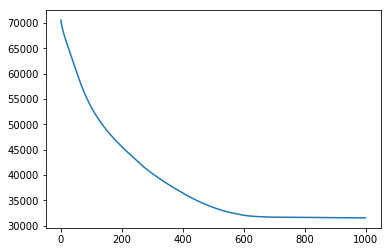

In [54]:
plt.plot(trace)

In [96]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final).numpy().flatten()

In [110]:
roc_auc_score(y.flatten(), yhat)

0.6931322276718463

In [116]:
activations = tf.math.sigmoid( X @ W_hidden + b_hidden ).numpy()

In [142]:
# only columns with index 3 and 4 have any variance

In [157]:
neuron_1 = (activations[:,3]>0.5)
neuron_2 = (activations[:,4]>0.5)

In [171]:
df[neuron_1].mean()

avg_dist                    7.123171
avg_rating_by_driver        4.806855
avg_rating_of_driver        4.616371
avg_surge                   1.111759
surge_pct                  12.857591
trips_in_first_30_days      1.012661
luxury_car_user             0.310924
weekday_pct                92.431417
signup_dow                  2.889453
age                       164.737941
pass_rating_blank           0.006644
driver_rating_blank         0.252276
dtype: float64

In [168]:
df[neuron_2].mean()

avg_dist                    6.116270
avg_rating_by_driver        4.771641
avg_rating_of_driver        4.593224
avg_surge                   1.000000
surge_pct                   0.000000
trips_in_first_30_days      0.907870
luxury_car_user             0.247033
weekday_pct                 0.000625
signup_dow                  4.210493
age                       165.807152
pass_rating_blank           0.007964
driver_rating_blank         0.331355
dtype: float64

In [172]:
df[neuron_1].mean() - df[neuron_2].mean()

avg_dist                   1.006901
avg_rating_by_driver       0.035214
avg_rating_of_driver       0.023147
avg_surge                  0.111759
surge_pct                 12.857591
trips_in_first_30_days     0.104791
luxury_car_user            0.063891
weekday_pct               92.430792
signup_dow                -1.321041
age                       -1.069211
pass_rating_blank         -0.001319
driver_rating_blank       -0.079080
dtype: float64

Neuron 1 activates when a passenger takes surge ride and rides on the weekdays. Neuron 2 activates when the passenger rides less and only on the weekends. For about half of passengers, neither neuron activates.

In [217]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(6, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

def cross_entropy(y, yhat):
    return tf.reduce_sum(-(y*tf.math.log(yhat)+(1-y)*tf.math.log(1-yhat)))

model.compile(optimizer='adam',
              loss=cross_entropy)

hist = model.fit(X,y, epochs=1000, batch_size=1024)

Epoch 1/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 674.7974
Epoch 2/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 659.0413
Epoch 3/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 654.5189
Epoch 4/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 652.6453
Epoch 5/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 651.3531
Epoch 6/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 649.8944
Epoch 7/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 643.0210
Epoch 8/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 627.2972
Epoch 9/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 622.4288
Epoch 10/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 618.7809
Epoch 11/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 616.05

50000/50000 [==============================] - 0s 4us/sample - loss: 571.7342
Epoch 91/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 571.2355
Epoch 92/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 571.0434
Epoch 93/1000
50000/50000 [==============================] - 0s 6us/sample - loss: 570.8764
Epoch 94/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 571.0284
Epoch 95/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 570.7388
Epoch 96/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 570.5876
Epoch 97/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 570.0987
Epoch 98/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 569.9246
Epoch 99/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 569.8619
Epoch 100/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 569.9987
E

KeyboardInterrupt: 

In [218]:
yhat = (model.predict(X)>0.5).ravel()

In [219]:
roc_auc_score(y, yhat)

0.6819549934088062

In [237]:
W, b = model.layers[0].weights

In [238]:
hidden_activations = (tf.sigmoid( X @ W + b )>0.5).numpy()

In [256]:
df[ hidden_activations.T[0] ].mean()

avg_dist                    5.808791
avg_rating_by_driver        4.777735
avg_rating_of_driver        4.601857
avg_surge                   1.070598
surge_pct                   8.356494
trips_in_first_30_days      2.290342
luxury_car_user             0.377933
weekday_pct                61.130299
signup_dow                  3.303955
age                       165.482375
pass_rating_blank           0.003901
driver_rating_blank         0.160785
dtype: float64

In [270]:
# and so forth